In [1]:
import pandas as pd 
# 1. wczytajmy data frame z danymi "mieszkania.csv" (via pandas)

df = pd.read_csv("mieszkania.csv")

In [2]:
# 2. rzućmy okiem na pierwszych 10 wierszy dataframe'u [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html]
# TWÓJ KOD: 
df.head(10)

,powierzchnia,wiek,cena_pln
0,44,22,719000.0
1,69,4,1550000.0
2,27,12,545000.0
3,38,3,769000.0
4,50,5,1373000.0
5,30,14,635000.0
6,49,0,1337000.0
7,56,13,1297000.0
8,39,14,798000.0
9,75,20,984000.0


<Axes: >

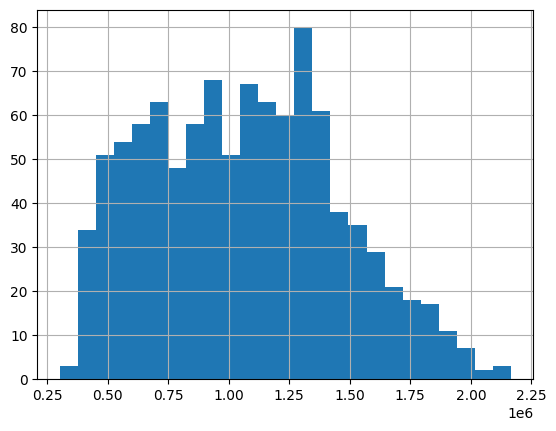

In [3]:
# 3. Rzućmy okiem na rozkłady (histogramy) ceny [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html] 
# TWÓJ KOD:
df.cena_pln.hist(bins=25)

<Axes: xlabel='powierzchnia', ylabel='cena_pln'>

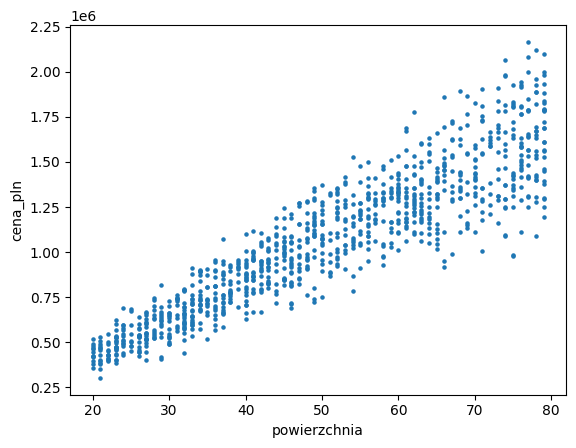

In [4]:
# 4. W jaki sposób cena zależy od powierzchni [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html] 
# użyj parametrów `marker` i `kind`
# TWÓJ KOD:

df.plot(x='powierzchnia', y='cena_pln', kind='scatter', marker='.')

### 3. Definicja modelu 
#### Uproszczony "zabawkowy" model liniowy 
$$
cena = w_{\text{wiek}} * x_{\text{wiek}} + w_{\text{powierzchnia}} * x_{\text{powierzchnia}}
$$

In [5]:
# Zdefiniujmy Grid parametrów (zakładamy wiedzę domenową) 
# https://www.w3schools.com/python/ref_list_append.asp


from tqdm import tqdm 
import matplotlib.pyplot as plt

GRID = {
    'powierzchnia': list(range(8000, 25000, 2000)), 
    'wiek': list(range(-25000, 1000, 500))
}

def plot_grid():
    points = []
    
    for i, w_wiek_i in enumerate(GRID['wiek']):
        for j, w_powierzchnia_j in enumerate(GRID['powierzchnia']):            
            points.append((w_wiek_i, w_powierzchnia_j)) 

    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.figure(figsize=(10,5))

    plt.scatter(x, y, marker='.')

    plt.xlabel('parametr wiek')
    plt.ylabel('parametr powierzchnia')


In [6]:
from tqdm import tqdm 

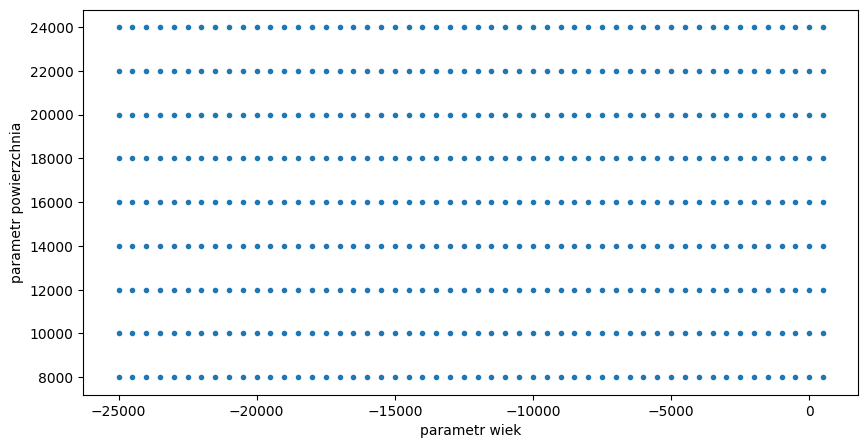

In [7]:
plot_grid()

In [8]:
from typing import List 
import numpy as np 

def compute_mse(predicted_y_cena: pd.Series, y_cena: pd.Series) -> float:
    mse = 0.0 
    for i, single_predicted_cena in enumerate(predicted_y_cena):
        single_cena = y_cena[i] 
        mse += (single_cena - single_predicted_cena)**2 
    return mse / len(predicted_y_cena) 
            
    
class ToyLinearModel:

    def __init__(self, weight_wiek = 0, weight_powierzchnia = 0):
        self.weight_wiek = weight_wiek 
        self.weight_powierzchnia = weight_powierzchnia

    def predict(self, wiek: pd.Series, powierzchnia: pd.Series) -> pd.Series:
        return self.weight_powierzchnia * powierzchnia + self.weight_wiek * wiek

    def train(self, x_wiek: pd.Series, x_powierzchnia: pd.Series, y_cena: pd.Series):
        assert len(x_wiek) == len(x_powierzchnia) == len(y_cena)
        best_mse = np.inf
        best_weight_wiek = 0 
        best_weight_powierzchnia = 0
        mses = []
        for weight_powierzchnia in tqdm(GRID['powierzchnia']):
            for weight_wiek in GRID['wiek']:
                self.weight_wiek = weight_wiek
                self.weight_powierzchnia = weight_powierzchnia
                predicted_y_cena = self.predict(wiek=x_wiek, powierzchnia=x_powierzchnia)
                current_mse = compute_mse(predicted_y_cena, y_cena) # TODO 
                if best_mse > current_mse:
                    best_weight_wiek = weight_wiek
                    best_weight_powierzchnia = weight_powierzchnia
                    best_mse = current_mse
                    mses.append(best_mse)
        print(f"Found best params to be {best_weight_wiek=} and {best_weight_powierzchnia=}")
        self.weight_wiek = best_weight_wiek
        self.weight_powierzchnia = best_weight_powierzchnia
        return mses 
        

In [9]:
model = ToyLinearModel()
mses = model.train(x_wiek=df.wiek, x_powierzchnia=df.powierzchnia, y_cena=df.cena_pln)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.90it/s]

Found best params to be best_weight_wiek=-12500 and best_weight_powierzchnia=24000


<Axes: >

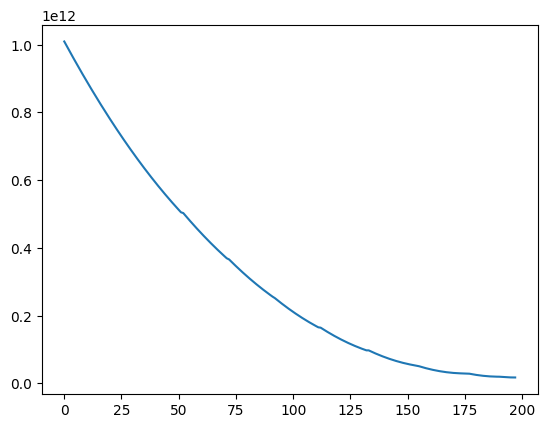

In [10]:
# Zobaczmy jak wyglądał postęp minimalizowania mse (plot mse_list) 

pd.Series(mses).plot() 

In [11]:
predicted_prices = df.apply(
    lambda x : model.predict(x.wiek, x.powierzchnia), 
    axis=1
)

# dodajmy kolumne "predykowana_cena_pln" [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html]
df = df.assign(predykowana_cena_pln = predicted_prices)

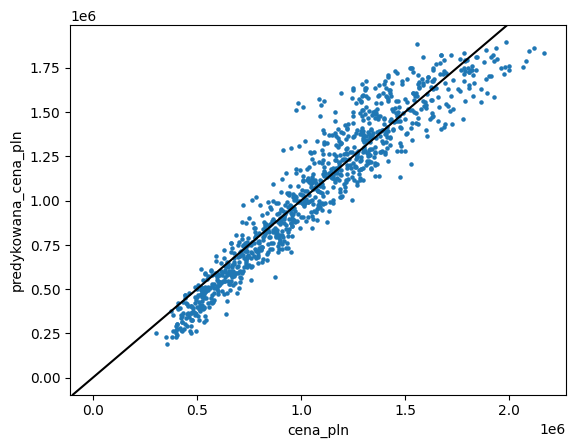

In [12]:
# Zobaczmy jak blisko jesteśmy "idealnego" dopasowania
ax = df.plot(x='cena_pln', y = 'predykowana_cena_pln', marker='.', kind='scatter') # TODO  
ax.axline((0,0), slope=1, color='black')